# Определение возраста покупателей

# Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# Инструкция по выполнению проекта
- Проведите исследовательский анализ набора фотографий.
- Подготовьте данные к обучению.
- Обучите нейронную сеть и рассчитайте её качество.

# Обучение модели 
- Постройте и обучите свёрточную нейронную сеть на датасете с фотографиями людей. Добейтесь значения MAE на тестовой выборке не больше 8.
- Функцию загрузки тестовой выборки `load_test(path)` напишите самостоятельно. Вместе со старыми функциями в коде должны быть:
```load_train(path),
load_test(path),
create_model(input_shape),
train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)```

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.losses import MeanAbsoluteError
import pandas as pd

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(dataframe=data,
                                           directory='/datasets/faces/final_files/',
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=(224, 224),
                                           batch_size=16,
                                           class_mode='raw'
                                          )

Found 7591 validated image filenames.


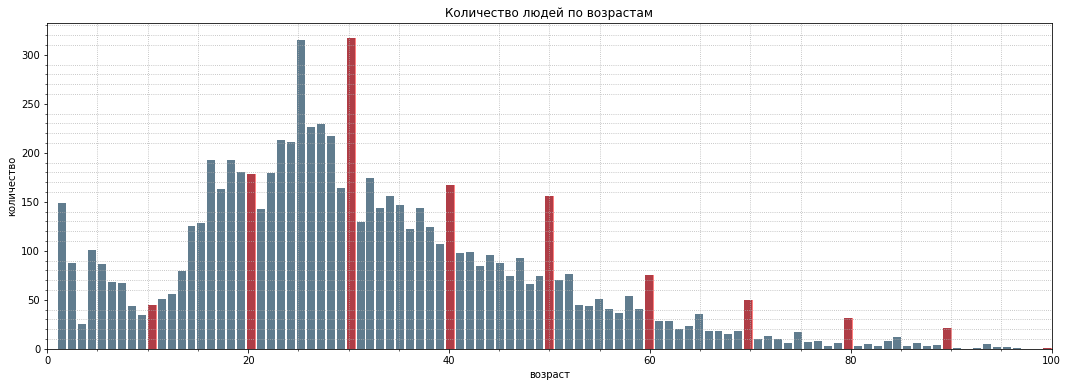

In [4]:
fig = plt.figure(figsize=(18,6))
data['real_age'].plot(kind='hist', 
                      bins=100, 
                      rwidth=0.8, 
                      xlim=(0,100), 
                      grid=True,
                      color='#607c8e'
                     )
plt.hist(data.loc[(data['real_age'] % 10) == 0, ['real_age']],bins = 100, alpha = 0.5, 
         color = 'red')
plt.xlabel('возраст')
plt.ylabel('количество')
plt.title('Количество людей по возрастам')
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.show()

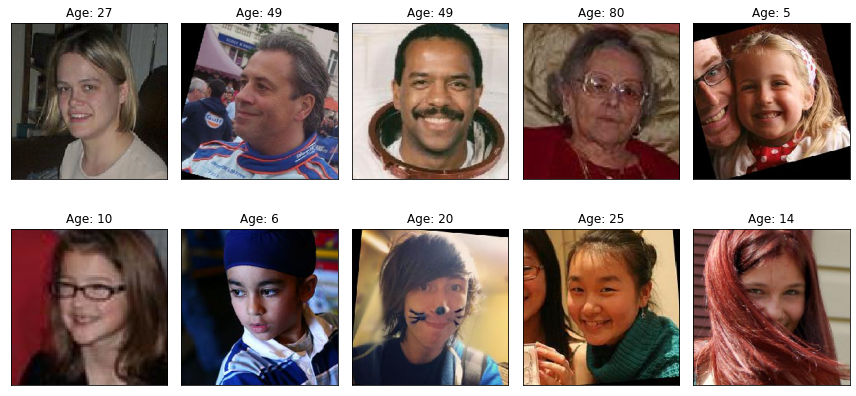

In [5]:
images, ages = next(datagen_flow)
fig = plt.figure(figsize=(12,9))
for i in range(10):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(images[i])
    plt.title(f'Age: {ages[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

# Отчет иследовательского анализа :
* большая часть фото людей с 16 до 30 лет 
* есть большой пик детских фотографий
* так-же видно много фото людей с кратным 10 возрастом начиная с 30 лет
* фотографии имеют различия, фото могут быть повернуты, растянуты , не на весь формат , люди на них могут быть повернуты в разные стороны, есть черно-белые фото 

# Вывод :
- Импортировал библтотеки
- Открыл файл
- Разделил датасет на изображения и целевые признаки 
- Вывел график с количеством фото людей разных возрастов
- Вывел первые 10 фото Батча

## Обучение модели

(Код в этом разделе запускался в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.3, rescale=1. / 255)
    datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                               directory=path + 'final_files/',
                                               x_col='file_name',
                                               y_col='real_age',
                                               target_size=(224, 224),
                                               batch_size=16,
                                               class_mode='raw',
                                               subset='training',
                                               seed=12345
                                               )
    return datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.3, rescale=1. / 255)
    datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                               directory=path + 'final_files/',
                                               x_col='file_name',y_col='real_age',
                                               target_size=(224, 224),
                                               batch_size=16,
                                               class_mode='raw',
                                               subset='validation',
                                               seed=12345
                                               )
    return datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                         weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                         include_top=False
                         )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr= 0.0001)
    model.compile(optimizer=optimizer,
                 loss=MeanAbsoluteError(),
                 metrics=['mae']
                 )
    return model

def train_model(model, train_data,
                test_data, batch_size=None,
                epochs=10,steps_per_epoch=None,
                validation_steps=None
                ):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2
              )
    return model
    ```

```Found 5314 validated image filenames.
Found 2277 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 333 steps, validate for 143 steps
Epoch 1/9
333/333 - 69s - loss: 221.2637 - mae: 10.7189 - val_loss: 577.2755 - val_mae: 18.9964
Epoch 2/9
333/333 - 38s - loss: 71.2628 - mae: 6.4169 - val_loss: 160.7660 - val_mae: 9.8622
Epoch 3/9
333/333 - 38s - loss: 38.2864 - mae: 4.7821 - val_loss: 89.0235 - val_mae: 7.0338
Epoch 4/9
333/333 - 38s - loss: 26.4713 - mae: 3.9210 - val_loss: 94.1152 - val_mae: 7.5272
Epoch 5/9
333/333 - 38s - loss: 19.7440 - mae: 3.3832 - val_loss: 70.4367 - val_mae: 6.3906
Epoch 6/9
333/333 - 38s - loss: 15.6402 - mae: 3.0056 - val_loss: 75.6335 - val_mae: 6.8191
Epoch 7/9
333/333 - 38s - loss: 11.7982 - mae: 2.6356 - val_loss: 96.4293 - val_mae: 7.2927
Epoch 8/9
333/333 - 38s - loss: 10.6712 - mae: 2.4863 - val_loss: 73.6546 - val_mae: 6.3690
Epoch 9/9
333/333 - 38s - loss: 10.2616 - mae: 2.4216 - val_loss: 66.9103 - val_mae: 6.1025
143/143 - 11s - loss: 66.9103 - mae: 6.1025
Test MAE: 6.1025
```

## Анализ обученной модели

- Используя ResNet50 добился точности предсказаний в 6,1 года , что удовлетворяет условие задачи (8 лет)
- Функцией потерь не обязательно должна быть MAE. Зачастую нейронные сети с функцией потерь MSE обучаются быстрее.
- Также для улучшения модели можно было использовать другие инструменты аугментации, так же можно рассмотреть добавление слоев и методов борьбы с переобучением

